In [ ]:
!pip install wfdb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("✓ Drive mounted!")

# ═══════════════════════════════════════════════════════════════════════════
# SECTION 3: IMPORTS
# ═══════════════════════════════════════════════════════════════════════════

import os, ast, json, warnings
from typing import Dict, List, Tuple, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance, ks_2samp
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import wfdb
from tqdm import tqdm

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
print("✓ Imports done!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Drive mounted!
✓ Imports done!


In [ ]:
class PTBXLDataLoader:
    def __init__(self, data_path, sampling_rate=100):
        self.data_path = data_path
        self.sampling_rate = sampling_rate
        self.database = None
        self.scp_statements = None
        self.train_ids = []
        self.val_ids = []
        self.test_ids = []

    def load_metadata(self):
        print("Loading metadata...")
        self.database = pd.read_csv(os.path.join(self.data_path, 'ptbxl_database.csv'), index_col='ecg_id')
        self.scp_statements = pd.read_csv(os.path.join(self.data_path, 'scp_statements.csv'), index_col=0)
        self.database['scp_codes'] = self.database['scp_codes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})
        print(f"✓ Loaded {len(self.database)} records")
        return self

    def aggregate_diagnostic_labels(self):
        def aggregate_codes(codes_dict):
            labels = []
            for code in codes_dict.keys():
                if code in self.scp_statements.index:
                    diagnostic_class = self.scp_statements.loc[code, 'diagnostic_class']
                    if pd.notna(diagnostic_class):
                        labels.append(diagnostic_class)
            return list(set(labels))
        self.database['diagnostic_superclass'] = self.database['scp_codes'].apply(aggregate_codes)
        return self

    def load_ecg_signal(self, ecg_id):
        data_path = self.database.loc[ecg_id, 'filename_lr' if self.sampling_rate == 100 else 'filename_hr']
        signal, _ = wfdb.rdsamp(os.path.join(self.data_path, data_path))
        metadata = {
            'ecg_id': ecg_id,
            'age': self.database.loc[ecg_id, 'age'],
            'sex': self.database.loc[ecg_id, 'sex'],
            'diagnostic_superclass': self.database.loc[ecg_id, 'diagnostic_superclass']
        }
        return signal, metadata

    def prepare_train_test_split(self):
        self.train_ids = self.database[self.database['strat_fold'].isin(range(1, 9))].index.tolist()
        self.val_ids = self.database[self.database['strat_fold'] == 9].index.tolist()
        self.test_ids = self.database[self.database['strat_fold'] == 10].index.tolist()
        print(f"Train: {len(self.train_ids)}, Val: {len(self.val_ids)}, Test: {len(self.test_ids)}")
        return self

In [ ]:
class ECGInstructionDataset(Dataset):
    def __init__(self, data_loader, ecg_ids, tokenizer, max_length=1024):
        self.data_loader = data_loader
        self.ecg_ids = ecg_ids
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.ecg_ids)

    def __getitem__(self, idx):
        ecg_id = self.ecg_ids[idx]
        signal, meta = self.data_loader.load_ecg_signal(ecg_id)

        diagnosis = ", ".join(meta['diagnostic_superclass']) if meta['diagnostic_superclass'] else "normal"
        prompt = f"Generate ECG for {meta['age']}y {meta['sex']} with {diagnosis}"

        tokenized = self.tokenizer(prompt, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        return {
            'input_ids': tokenized['input_ids'].squeeze(),
            'attention_mask': tokenized['attention_mask'].squeeze(),
            'labels': tokenized['input_ids'].squeeze()
        }

In [ ]:
class SimpleECGGenerator:
    """Simplified generator without bitsandbytes"""

    def __init__(self, model_name="TinyLlama/TinyLlama-1.1B-Chat-v1.0"):
        self.model_name = model_name
        self.tokenizer = None
        self.model = None

    def setup_model(self):
        print(f"\n🚀 Loading {self.model_name}...")
        print("This is a small model - works on free Colab T4 GPU!")

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # Load model in float16 (no quantization needed)
        print("Loading model in FP16 precision...")
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16,
            device_map="auto"
        )

        # Add LoRA for efficient training
        print("Adding LoRA adapters...")
        lora_config = LoraConfig(
            r=8,  # Smaller rank for faster training
            lora_alpha=16,
            target_modules=["q_proj", "v_proj"],
            lora_dropout=0.05,
            bias="none",
            task_type="CAUSAL_LM"
        )
        self.model = get_peft_model(self.model, lora_config)
        self.model.print_trainable_parameters()
        print("✓ Model ready!")
        return self

    def train(self, train_dataset, val_dataset, output_dir="./ecg_model", num_epochs=2, batch_size=2):
        print(f"\n🏋️ Training for {num_epochs} epochs...")

        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            gradient_accumulation_steps=4,
            learning_rate=3e-4,
            warmup_steps=50,
            logging_steps=10,
            eval_strategy="steps",
            eval_steps=100,
            save_strategy="steps",
            save_steps=200,
            fp16=True,
            report_to="none"
        )

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset
        )

        trainer.train()
        trainer.save_model(output_dir)
        print(f"✓ Model saved to {output_dir}")
        return self

    def generate(self, prompt, max_tokens=512):
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=0.7,
            do_sample=True
        )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
class ECGVisualizer:
    @staticmethod
    def plot_ecg(signal, title="ECG", save_path=None):
        leads = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        fig, axes = plt.subplots(12, 1, figsize=(15, 12), sharex=True)
        fig.suptitle(title, fontsize=16, fontweight='bold')

        for i, (ax, lead) in enumerate(zip(axes, leads)):
            ax.plot(signal[:, i], 'k-', linewidth=0.8)
            ax.set_ylabel(lead, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_ylim(-2, 2)

        axes[-1].set_xlabel('Samples')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=200, bbox_inches='tight')
            print(f"✓ Saved: {save_path}")
        else:
            plt.show()
        plt.show()

print("✓ All classes loaded!")

✓ All classes loaded!


In [ ]:
def quick_demo():
    """Just visualize - no training!"""
    DATA = "/content/drive/MyDrive/PTBXL.0.3"
    OUT = "/content/outputs"
    os.makedirs(OUT, exist_ok=True)

    print("\n" + "="*80)
    print("📊 QUICK DEMO - Visualizing ECGs")
    print("="*80)

    # Load
    loader = PTBXLDataLoader(DATA)
    loader.load_metadata().aggregate_diagnostic_labels().prepare_train_test_split()

    # Plot 5 samples
    viz = ECGVisualizer()
    for i in tqdm(range(5), desc="Creating plots"):
        signal, meta = loader.load_ecg_signal(loader.test_ids[i])
        dx = ", ".join(meta['diagnostic_superclass']) if meta['diagnostic_superclass'] else "Normal"
        viz.plot_ecg(signal, f"ECG {i+1}: {meta['age']}y {meta['sex']}, {dx}", f"{OUT}/ecg_{i+1}.png")

    print(f"\n✓ Done! Check {OUT} folder")


In [ ]:
def train_model():
    """Train the model - simplified version"""
    DATA = "/content/drive/MyDrive/PTBXL.0.3"
    OUT = "/content/outputs"
    MODEL = "/content/ecg_model"
    os.makedirs(OUT, exist_ok=True)

    print("\n" + "="*80)
    print("🤖 TRAINING ECG GENERATOR")
    print("="*80)

    # Load data
    print("\n[1/4] Loading data...")
    loader = PTBXLDataLoader(DATA)
    loader.load_metadata().aggregate_diagnostic_labels().prepare_train_test_split()

    # Setup model
    print("\n[2/4] Setting up model...")
    generator = SimpleECGGenerator()
    generator.setup_model()

    # Create datasets (use small subset for demo)
    print("\n[3/4] Preparing datasets...")
    train_data = ECGInstructionDataset(loader, loader.train_ids[:500], generator.tokenizer)
    val_data = ECGInstructionDataset(loader, loader.val_ids[:100], generator.tokenizer)
    print(f"Train: {len(train_data)}, Val: {len(val_data)}")

    # Train
    print("\n[4/4] Training... (this takes 20-30 min)")
    generator.train(train_data, val_data, output_dir=MODEL, num_epochs=2, batch_size=2)

    # Test generation
    print("\n🎨 Testing generation...")
    test_prompt = "Generate ECG for 65y male with myocardial infarction"
    result = generator.generate(test_prompt)
    print(f"Prompt: {test_prompt}")
    print(f"Generated: {result[:200]}...")

    # Visualize a real ECG for comparison
    viz = ECGVisualizer()
    signal, meta = loader.load_ecg_signal(loader.test_ids[0])
    viz.plot_ecg(signal, "Real ECG Example", f"{OUT}/real_ecg.png")

    print(f"\n✓ Training complete!")
    print(f"Model: {MODEL}")
    print(f"Outputs: {OUT}")



🤖 TRAINING ECG GENERATOR

[1/4] Loading data...
Loading metadata...
✓ Loaded 21799 records
Train: 17418, Val: 2183, Test: 2198

[2/4] Setting up model...

🚀 Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0...
This is a small model - works on free Colab T4 GPU!
Loading model in FP16 precision...


The model is already on multiple devices. Skipping the move to device specified in `args`.


Adding LoRA adapters...
trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023
✓ Model ready!

[3/4] Preparing datasets...
Train: 500, Val: 100

[4/4] Training... (this takes 20-30 min)

🏋️ Training for 2 epochs...


Step,Training Loss,Validation Loss
100,0.007700,0.008897


✓ Model saved to /content/ecg_model

🎨 Testing generation...
Prompt: Generate ECG for 65y male with myocardial infarction
Generated: Generate ECG for 65y male with myocardial infarction with STTC and HD...
✓ Saved: /content/outputs/real_ecg.png


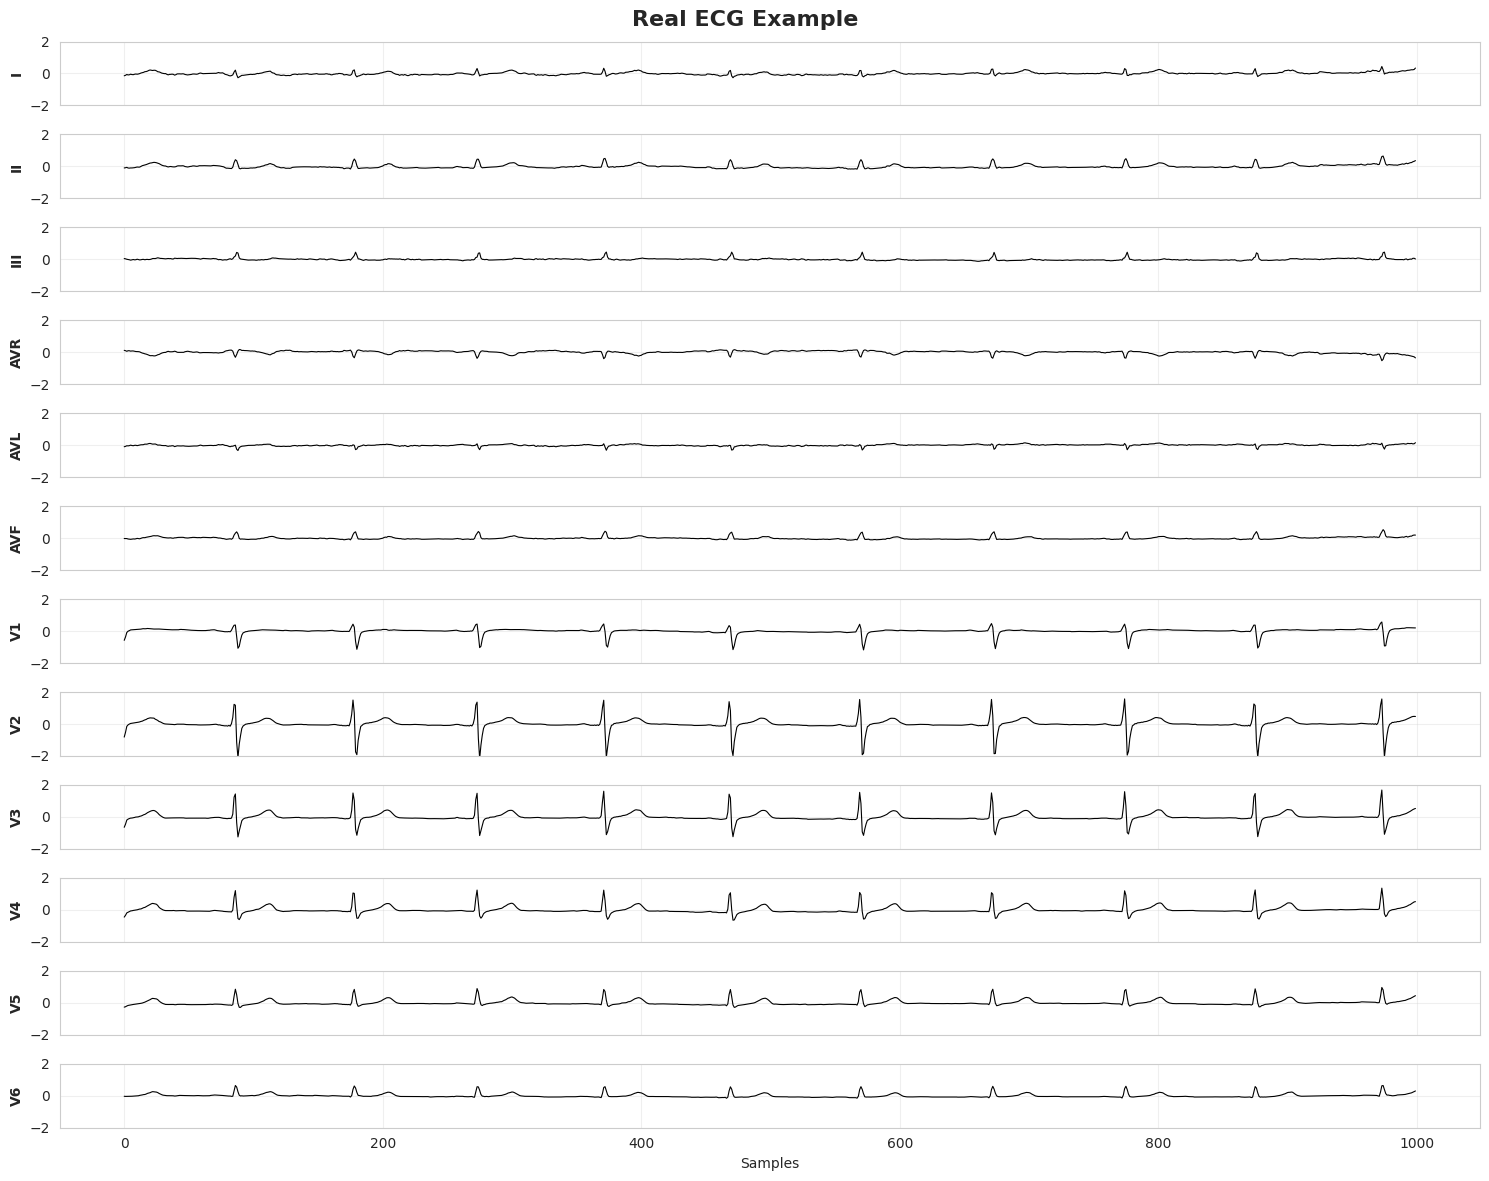


✓ Training complete!
Model: /content/ecg_model
Outputs: /content/outputs


In [ ]:
train_model()


📊 QUICK DEMO - Visualizing ECGs
Loading metadata...
✓ Loaded 21799 records
Train: 17418, Val: 2183, Test: 2198


Creating plots:   0%|          | 0/5 [00:00<?, ?it/s]

✓ Saved: /content/outputs/ecg_1.png


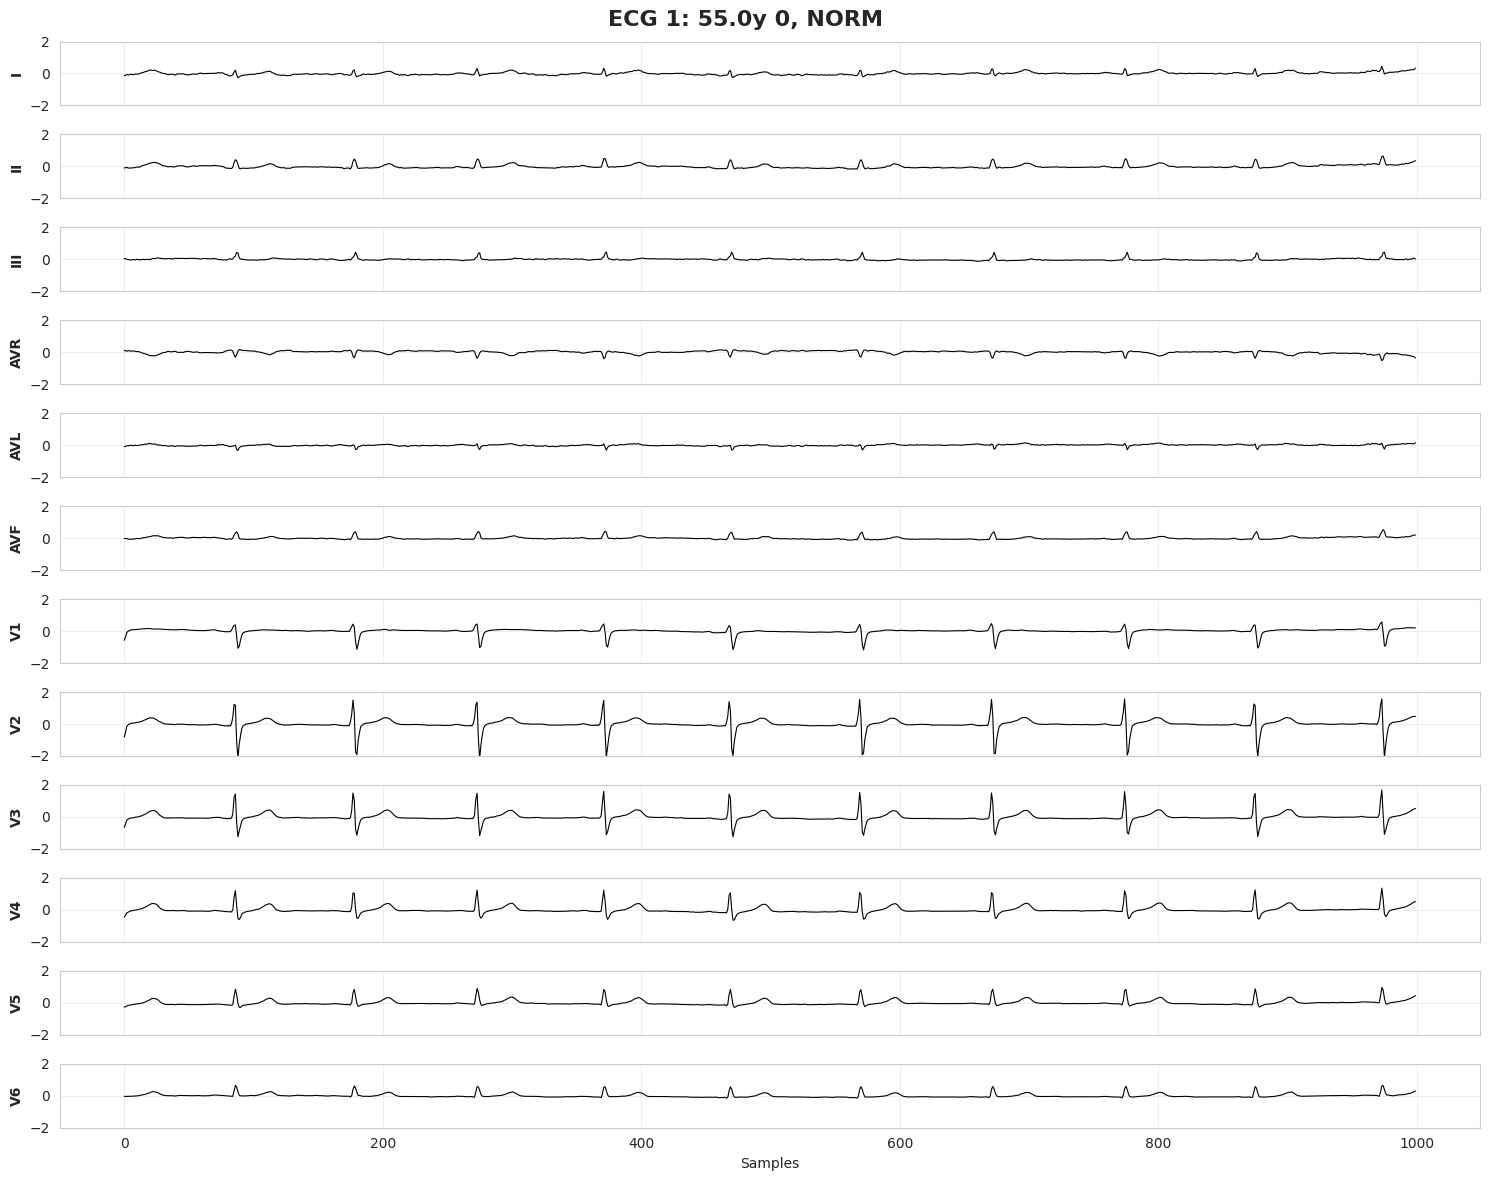

Creating plots:  20%|██        | 1/5 [00:01<00:07,  1.75s/it]

✓ Saved: /content/outputs/ecg_2.png


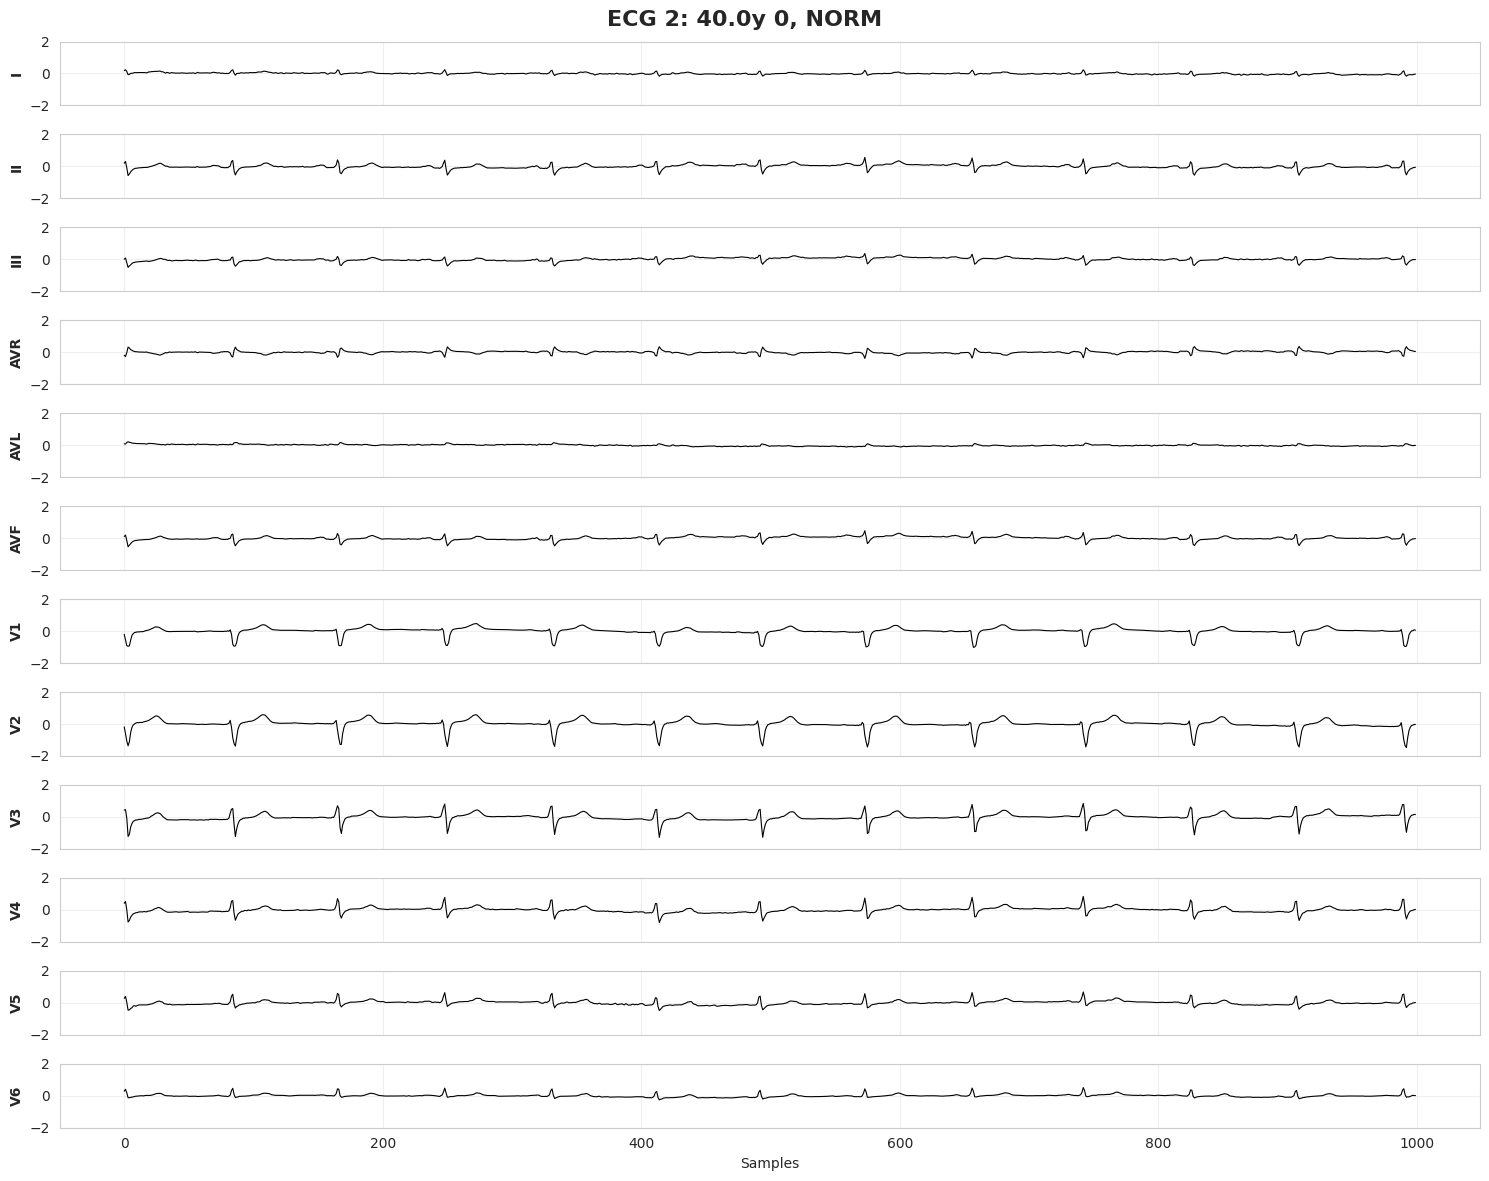

Creating plots:  40%|████      | 2/5 [00:03<00:05,  1.75s/it]

✓ Saved: /content/outputs/ecg_3.png


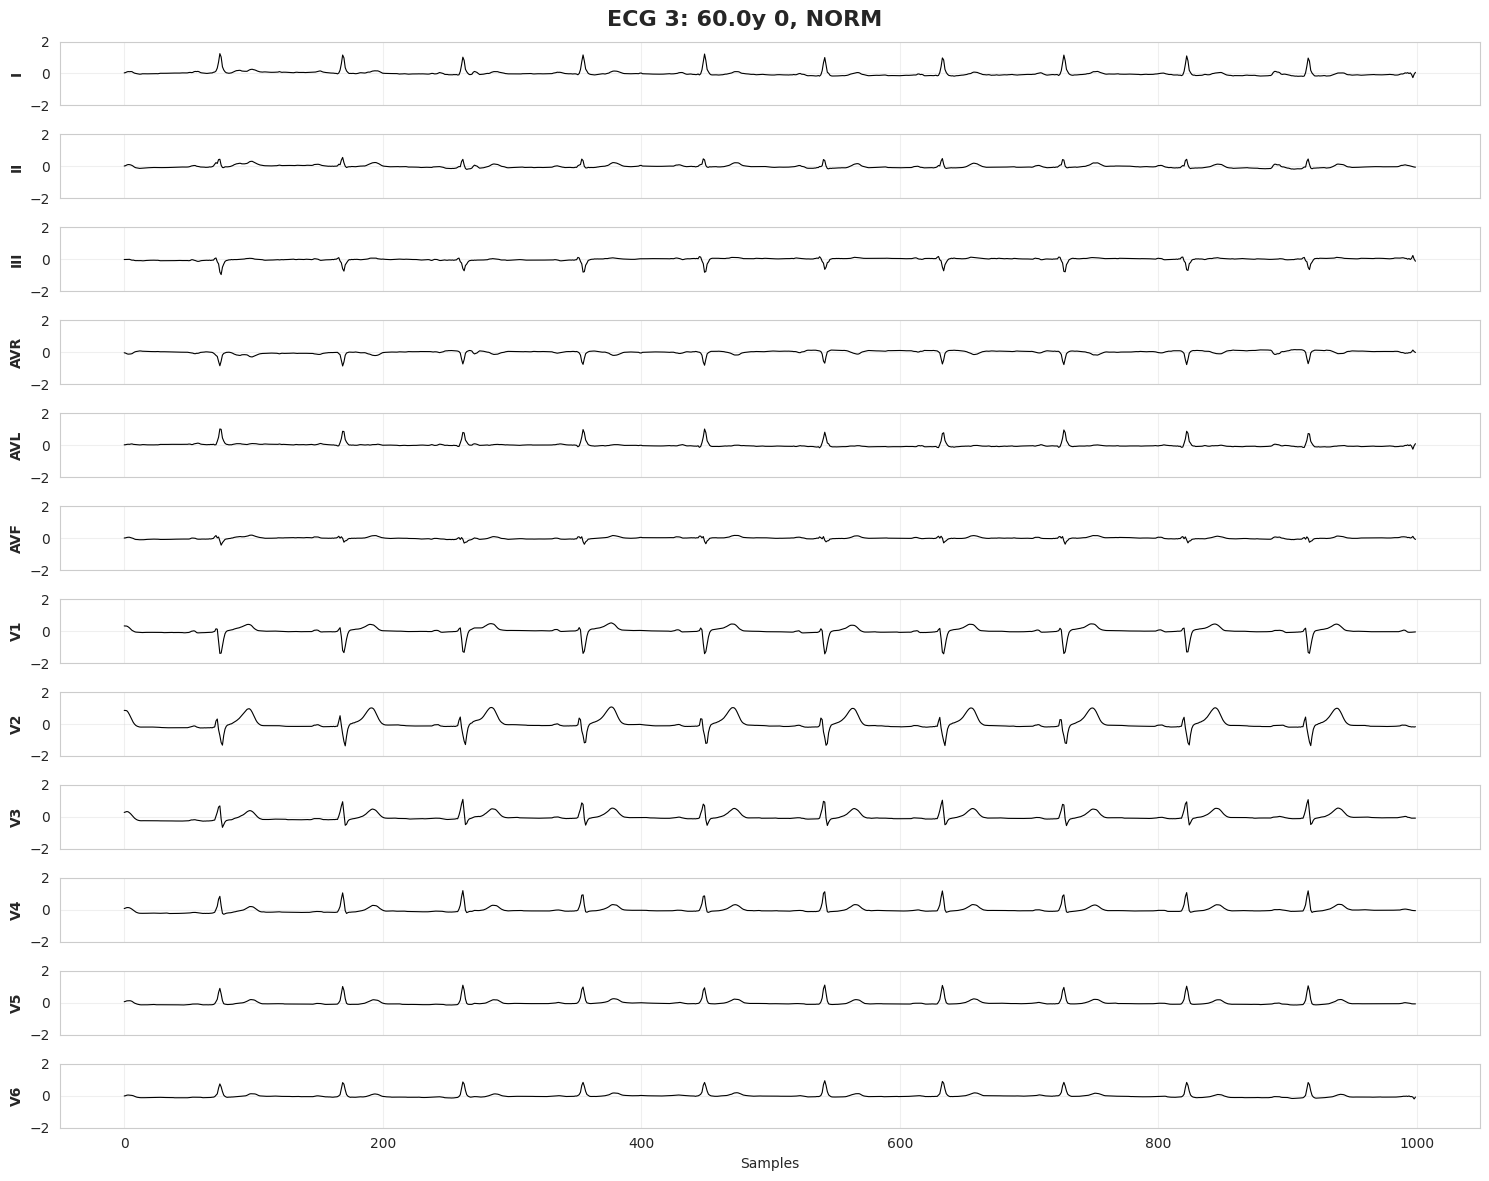

Creating plots:  60%|██████    | 3/5 [00:05<00:03,  1.75s/it]

✓ Saved: /content/outputs/ecg_4.png


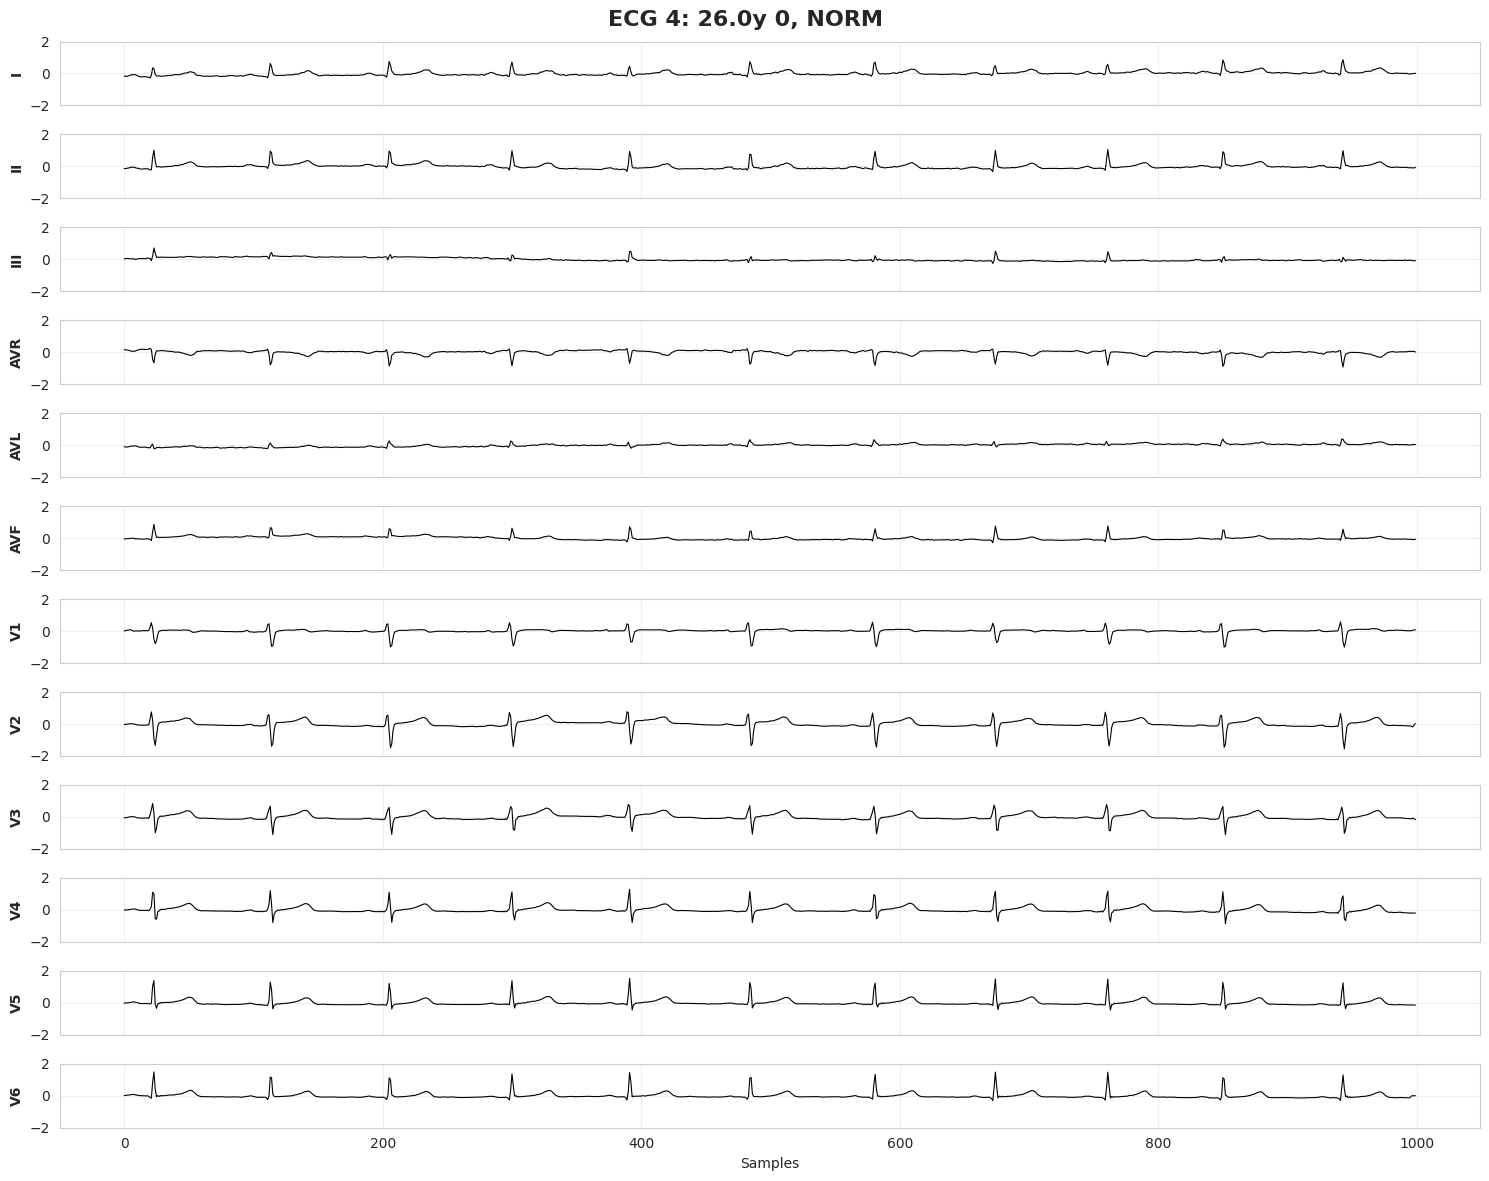

Creating plots:  80%|████████  | 4/5 [00:07<00:01,  1.76s/it]

✓ Saved: /content/outputs/ecg_5.png


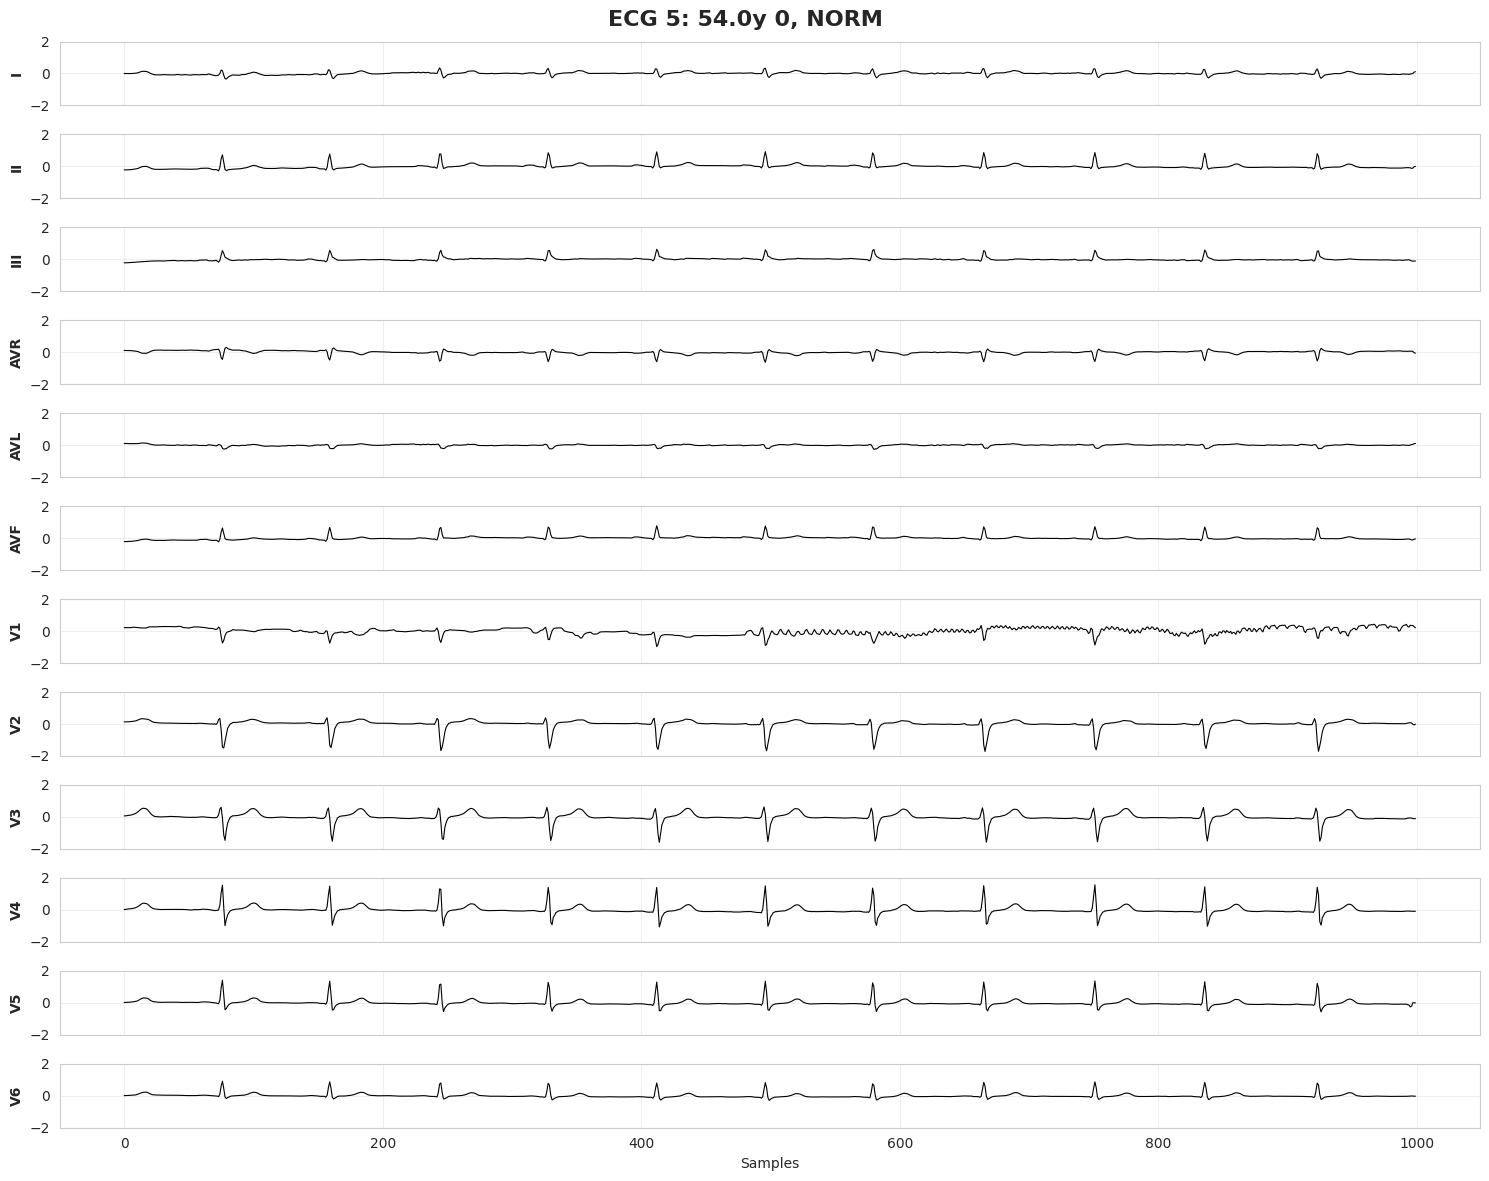

Creating plots: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


✓ Done! Check /content/outputs folder


In [ ]:
quick_demo()